In [64]:
from analyze_language_change import Mail, import_corpus, linear_prediction, occurrence_freq_by_year, occurrences_by_year, plot_word_timeseries
from pydantic import TypeAdapter
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np 

In [65]:
corpus_12_25 = import_corpus(batch_size=100, streaming=False, url="julilili42/tagesschau")
uni_mails = import_corpus(batch_size=100, streaming=False, url="DerSandmannHD/Uni-Mail", adapter = TypeAdapter(list[Mail]))

In [66]:
rows = [(a.date.year, a.article) for a in corpus_12_25]
year, articles = zip(*rows)

3096 articles to be loaded for dataset uni-mail


In [67]:
# distribution of articles for years
year_distribution = pd.Series(year).value_counts().sort_index()
# generate word matrix 
vec = CountVectorizer(max_features=100000, binary=True)
word_matrix_bin = vec.fit_transform(articles)
vocab = vec.get_feature_names_out()

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Number of articles')

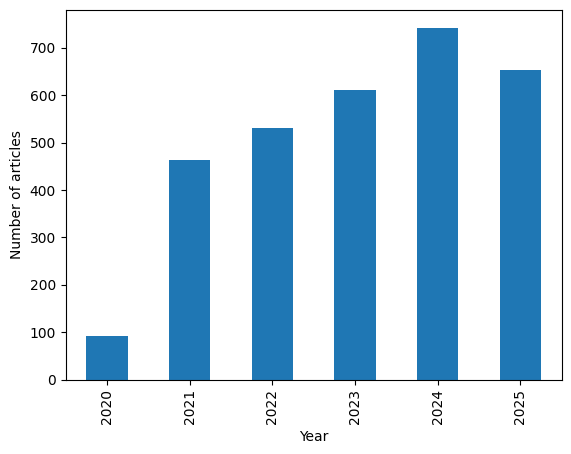

In [68]:
ax = year_distribution.plot(kind="bar")
ax.set_xlabel("Year")
ax.set_ylabel("Number of articles")

In [69]:
occurence_freq = occurrence_freq_by_year(year=year, word_matrix_bin=word_matrix_bin, vocab=vocab)
occurence_counts = occurrences_by_year(year=year, word_matrix=word_matrix_bin, vocab=vocab)

Goal: try to find words which disproportionaly increased in use, by interpolating use in year 2024 

- frequency gap $\delta = p - q$ $\implies$ highlights excess usage of frequent words
- frequency ratio $r = \frac{p}{q}$ $\implies$ highlights excess usage of infrequent words.

In [70]:

eps = 1e-6


# dataframe containing frequencies before introduction of llm's
train = occurence_freq.loc[2020:2022]
train_baseline = train.mean()

# empirical frequency
p = occurence_freq.loc[2024] 

# absolute growth from baseline in percent
growth_abs = (p - train_baseline) / (train_baseline + eps)

# linear interpolation, frequency value of 2024
q = train.apply(linear_prediction, axis=0)

# Metric 1: frequency gap delta = p - q
delta = p - q

# Metric 2: frequency ratio r = p/q
min_q = 5e-4
min_p = 5e-3
mask = (q > min_q) & (p > min_p)
r = p[mask] / q[mask]

sorted_freq_gap = delta.sort_values(ascending=False).head(20)
sorted_freq_ratio = r.sort_values(ascending=False).head(50)

sorted_freq_mean = growth_abs.sort_values(ascending=False).head(20)
sorted_freq_mean

2025                         45760.430686
2156                         26917.900404
behavioral                   25572.005384
ranft                        24226.110363
32727                        21534.320323
2925                         21534.320323
77165                        21534.320323
contacts                     20188.425303
gesundheitswissenschaften    20188.425303
organising                   18842.530283
irtg2804                     18842.530283
barrierefreiheit             18842.530283
workshopformats              17496.635262
translational                17496.635262
mikrostruktur                16150.740242
grit                         16150.740242
weishaupt                    16150.740242
confirmation                 16150.740242
ganzkörper                   16150.740242
hib                          16150.740242
dtype: float64

In [71]:
metrics = pd.DataFrame({"p": p, "q": q, "growth": growth_abs})

metrics["delta"] = metrics["p"] - metrics["q"]
metrics["r"] = metrics["p"] / np.maximum(metrics["q"], eps)

mask_ratio = (metrics["q"] > min_q) & (metrics["p"] > min_p)
excess = metrics.loc[mask_ratio]

In [72]:
import spacy
nlp = spacy.load("de_core_news_lg")

words = list(excess.index)
pos_tags = {}
for doc in nlp.pipe(words, batch_size=500):
    token = doc[0]
    pos_tags[token.text] = token.pos_

allowed_pos = {"ADJ", "VERB"}
style_words = [w for w, pos in pos_tags.items() if pos in allowed_pos]

excess_style_words = excess.loc[excess.index.isin(style_words)].sort_values("growth", ascending=False)

In [73]:
llm_words = {
    "jedoch", "insbesondere", "beispielsweise", "weiterhin", "somit", "letztlich",
    "zugleich", "daraufhin", "entsprechend", "vermutlich", "wahrscheinlich",
    "insgesamt", "relevant", "bedeutend", "entscheidend", "zudem", "grundsätzlich",
    "dennoch", "außerdem", "daher", "deshalb", "dementsprechend", "trotzdem",
    "folglich", "anschließend", "vor allem", "darunter", "ferner", "vorher",
    "aktuell", "anschließend", "anschließend", "bisher", "zuvor", "anschließend",
    "künftig", "ebenso", "hingegen", "beachtlich", "wesentlich", "notwendig",
    "gegebenenfalls", "typischerweise", "häufig", "gelegentlich", "zumeist",
    "oftmals", "grundlegend", "relevant", "weshalb", "demnach", "somit",
    "dementsprechend", "beachtenswert", "überdies", "hinreichend", "wesentlicher",
    "prägnant", "effektiv", "effizient", "weshalb", "sowohl", "einerseits",
    "andererseits"
}


found_llm_words = [w for w in llm_words if w in excess.index]

llm_in_df = excess.loc[excess.index.isin(found_llm_words)]

llm_in_df.sort_values("growth", ascending=False)

,p,q,growth,delta,r
gegebenenfalls,0.006729,0.979014,2.412114,-0.972284,0.006874
relevant,0.012113,0.995881,1.598223,-0.983768,0.012163
darunter,0.006729,0.983283,1.501185,-0.976553,0.006844
dennoch,0.012113,0.001282,0.712885,0.010831,9.447972
zugleich,0.017497,0.999513,0.683540,-0.982016,0.017505
zudem,0.071332,0.093672,0.305650,-0.022340,0.761510
jedoch,0.051144,0.040309,0.156027,0.010835,1.268813
sowohl,0.037685,0.018561,0.098290,0.019124,2.030290
trotzdem,0.012113,0.003050,-0.039711,0.009063,3.970954
zuvor,0.009421,0.010630,-0.084947,-0.001209,0.886265


In [ ]:
# save to markdown file
print(f"number of excess style words {len(excess_style_words)}")
with open("excess_style_words.md", "w") as f:
    f.write(excess_style_words.head(1000).to_string())

number of excess style words 981


82487

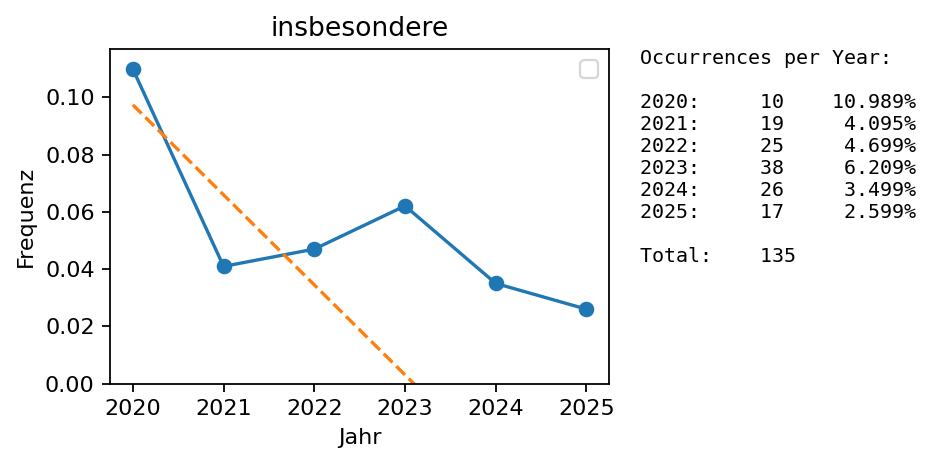

{'p': 0.034993270524899055,
 'q': 0.015853754035157725,
 'delta': 0.01913951648974133}

In [80]:
plot_word_timeseries(
  word="insbesondere", 
  occurence_freq=occurence_freq,
  occurrences_abs=occurence_counts,
  train_years=(2012, 2022),  #needs to adapted depending on corpus
  target_year=2024
)